# Code belows tests predictions from different adapters on the same image batch

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Plotting image with GT boxes


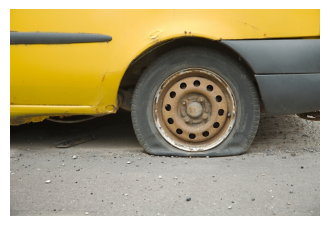

Using adapter: YoloUltralyticsAdapter
INFO ml_carbucks.adapters.UltralyticsAdapter 17:36:23 | Starting prediction...

0: 256x384 (no detections), 32.2ms
Speed: 1.1ms preprocess, 32.2ms inference, 0.3ms postprocess per image at shape (1, 3, 256, 384)


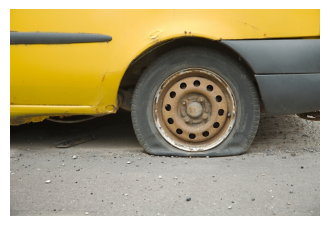

Using adapter: RtdetrUltralyticsAdapter
INFO ml_carbucks.adapters.UltralyticsAdapter 17:36:24 | Starting prediction...

0: 384x384 1 scratch, 11.9ms
Speed: 0.8ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 384)


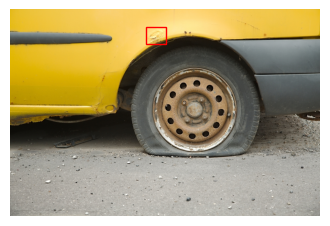

Using adapter: FasterRcnnAdapter


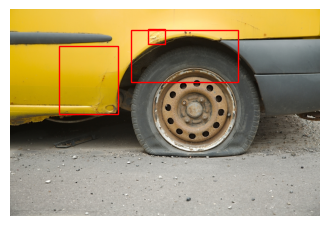

Using adapter: EfficientDetAdapter


/home/bachelor/ml-carbucks/ml_carbucks/adapters/EfficientDetAdapter.py:114: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  for i, pred in enumerate(outputs["detections"]):


IndexError: too many indices for tensor of dimension 3

In [1]:
from typing import List
from ml_carbucks import DATA_DIR
from ml_carbucks.adapters.BaseDetectionAdapter import BaseDetectionAdapter
from ml_carbucks.adapters.EfficientDetAdapter import EfficientDetAdapter
from ml_carbucks.adapters.FasterRcnnAdapter import FasterRcnnAdapter
from ml_carbucks.adapters.UltralyticsAdapter import RtdetrUltralyticsAdapter, YoloUltralyticsAdapter

from ml_carbucks.utils.inference import plot_img_pred as ppp
from ml_carbucks.utils.preprocessing import create_loader

adapters: List[BaseDetectionAdapter]=[
    YoloUltralyticsAdapter(
        classes=["scratch", "dent", "crack"],
        **{
            "img_size": 384,
            "batch_size": 32,
            "epochs": 27,
            "lr": 0.0015465639515144544,
            "momentum": 0.3628781599889685,
            "weight_decay": 0.0013127041660177367,
            "optimizer": "NAdam",
        },
        weights="/home/bachelor/ml-carbucks/results/ensemble_demos/trial_4_YoloUltralyticsAdaptermodel.pt",
    ),
    RtdetrUltralyticsAdapter(
        classes=["scratch", "dent", "crack"],
        **{
            "img_size": 384,
            "batch_size": 16,
            "epochs": 10,
            "lr": 0.0001141043015859849,
            "momentum": 0.424704619626319,
            "weight_decay": 0.00012292547851740234,
            "optimizer": "AdamW",
        },
        weights="/home/bachelor/ml-carbucks/results/ensemble_demos/trial_4_RtdetrUltralyticsAdaptermodel.pt",
    ),
    FasterRcnnAdapter(
        classes=["scratch", "dent", "crack"],
        **{
            "img_size": 384,
            "batch_size": 8,
            "epochs": 21,
            "lr_backbone": 2.6373762637681257e-05,
            "lr_head": 0.0011244046084737927,
            "weight_decay_backbone": 0.000796017512818448,
            "weight_decay_head": 0.0005747409908715994,
        },
        weights="/home/bachelor/ml-carbucks/results/ensemble_demos/trial_4_FasterRcnnAdaptermodel.pth",
    ),
    EfficientDetAdapter(
        classes=["scratch", "dent", "crack"],
        **{
            "img_size": 384,
            "batch_size": 8,
            "epochs": 26,
            "optimizer": "momentum",
            "lr": 0.003459928723120903,
            "weight_decay": 0.0001302610542371722,
        },
        weights="/home/bachelor/ml-carbucks/results/ensemble_demos/trial_4_EfficientDetAdaptermodel.pth",
    ),
]

# img_path = "/home/bachelor/ml-carbucks/data/car_dd_testing/images/val/000575.jpg"
# #load img as tensor
# from PIL import Image
# import torchvision.transforms as T
# img = Image.open(img_path).convert("RGB")
# transform = T.Compose([T.ToTensor()])
# batch_img_tensor = transform(img).unsqueeze(0)  # add batch dimension
# print("Plotting image with no predictions")
# ppp(batch_img_tensor[0], bboxes=[], coords="xyxy")


loader = create_loader(
    datasets=[
        (
            DATA_DIR / "car_dd_testing" / "images" / "val",
            DATA_DIR / "car_dd_testing" / "instances_val_curated.json",
        )
    ],
    shuffle=False,
    batch_size=1,
    transforms=None
)

figsize=(4,4)
jjj = 3
for batch in loader:
    batch_img_tensor, batch_targets = batch  # we only need the images

    for iii in range(len(batch_img_tensor)):

        print("Plotting image with GT boxes")        
        ppp(batch_img_tensor[iii], bboxes=batch_targets[iii]['boxes'], coords="xyxy", figsize=figsize, color="green")

        for adapter in adapters:
            print(f"Using adapter: {adapter.__class__.__name__}")
            adapter.setup()
            predictions = adapter.predict(batch_img_tensor)
            ppp(batch_img_tensor[iii], bboxes=predictions[iii]['boxes'], coords="xyxy", figsize=figsize)
    jjj -= 1
    if jjj == 0:
        break


# What is seen here is that EfficientDetAdapter explored with predictions - something is wrong there